In [2]:
### Necessary imports
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import fbeta_score

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
import shap

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Data download, Split into train and test

df_credit = pd.read_csv("german_credit.csv")
df_credit.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,NaN,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad


In [6]:
df_credit.Risk.value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

In [7]:
y = df_credit['Risk']
X = df_credit.drop(columns = ['Risk'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)

df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)

print(df_train.shape, df_test.shape)

(900, 10) (100, 10)


In [ ]:
# N.B.

#  When the data is randomly split into training and test sets, the distributions of both sets should be similar. However, it’s essential to validate the test set’s distribution, as it reflects the real-world data you’ll encounter during predictions. Ensuring that the test set represents the same distribution as the actual scenarios you’ll face is crucial for reliable model evaluation.

<Axes: >

<Axes: >

Text(0.5, 0, 'Credit History')

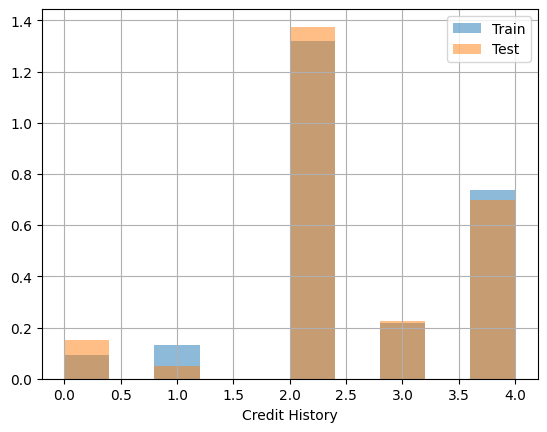

In [9]:
# Train and Test Distribution comparison

df_train['Credit History'].hist(alpha=0.5, label='Train', density=True)    
df_test['Credit History'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Credit History')
plt.legend()

<Axes: >

<Axes: >

Text(0.5, 0, 'Age')

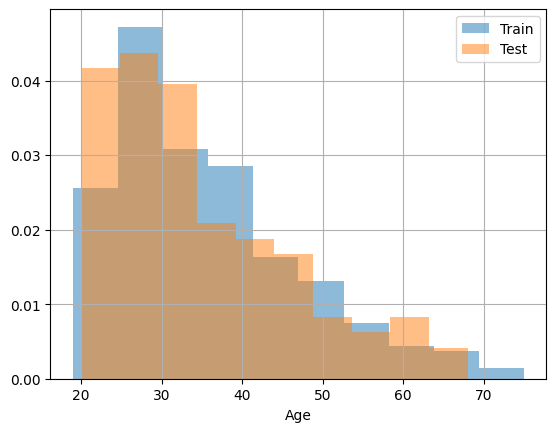

In [10]:
df_train.loc[:, 'Age'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Age'].hist(alpha=0.5, label='Test', density=True)  
plt.xlabel('Age')
plt.legend()

<Axes: >

<Axes: >

Text(0.5, 0, 'Job')

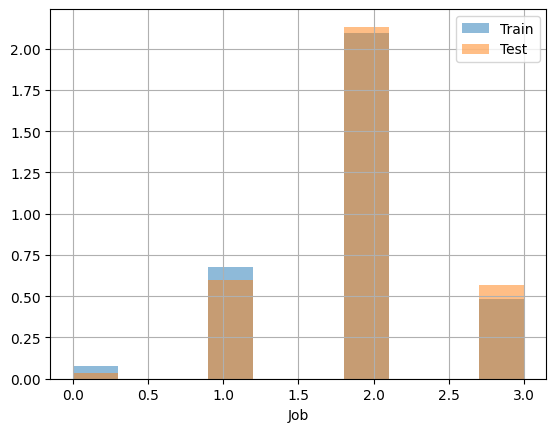

In [11]:
df_train.loc[:, 'Job'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Job'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Job')
plt.legend()

<Axes: >

<Axes: >

Text(0.5, 0, 'Duration')

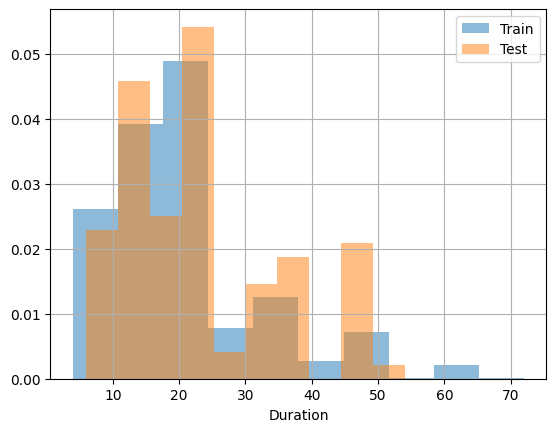

In [12]:
df_train.loc[:, 'Duration'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Duration'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Duration')
plt.legend()

<Axes: >

<Axes: >

Text(0.5, 0, 'Credit amount')

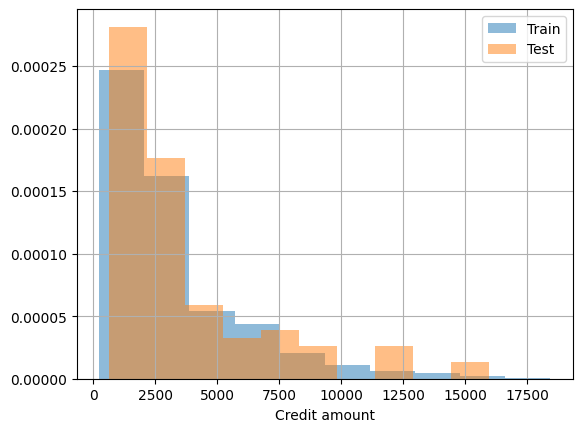

In [13]:
df_train.loc[:, 'Credit amount'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Credit amount'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Credit amount')
plt.legend()

<Axes: >

<Axes: >

Text(0.5, 0, 'Saving accounts')

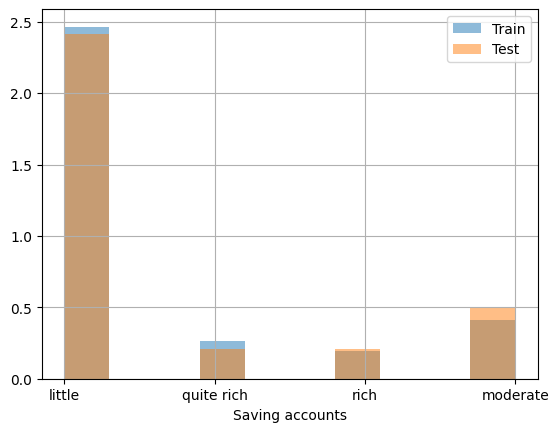

In [14]:
df_train.loc[:, 'Saving accounts'].hist(alpha=0.5, label='Train', density=True)    
df_test.loc[:, 'Saving accounts'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Saving accounts')
plt.legend()

In [16]:
from scipy.stats import ks_2samp

# if p values > 0.05, we can't reject the null hypotesis that the two distributions are the same, so we can consider them similar

ks_2samp(df_train['Age'], df_test['Age'])

KstestResult(statistic=0.08, pvalue=0.5899077794561494, statistic_location=35, statistic_sign=-1)

In [19]:
ks_2samp(df_train['Duration'], df_test['Duration'])

KstestResult(statistic=0.11777777777777777, pvalue=0.154479439979657, statistic_location=18, statistic_sign=1)

In [20]:
df_train.nunique()

Credit History       5
Age                 53
Gender               2
Job                  4
Housing              3
Saving accounts      4
Credit amount      838
Duration            33
Purpose              8
Risk                 2
dtype: int64

In [21]:
df_train.Risk.value_counts() ### Good = 1 (credit worthy), Bad = 0 (not worthy)

Risk
good    631
bad     269
Name: count, dtype: int64

In [22]:
df_train_summ = df_train.describe()
df_train_summ

,Credit History,Age,Job,Credit amount,Duration
count,900.000000,900.000000,900.000000,900.000000,900.000000
mean,2.548889,35.645556,1.896667,3228.406667,20.658889
std,1.081161,11.366477,0.656439,2772.428613,12.044240
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,2.000000,27.000000,2.000000,1360.750000,12.000000
50%,2.000000,33.000000,2.000000,2309.000000,18.000000
75%,4.000000,42.000000,2.000000,3959.000000,24.000000
max,4.000000,75.000000,3.000000,18424.000000,72.000000


In [23]:
df_train.describe(include='object')

,Gender,Housing,Saving accounts,Purpose,Risk
count,900,900,737,900,900
unique,2,3,4,8,2
top,male,own,little,car,good
freq,621,648,545,294,631


In [30]:
### the credit amount is highly skewed distribution, lets analyse the extreme values beyond 3 sigma (mean + 3*std)
def extreme_count(sig_factor, feat):
    sig_cutoff = df_train_summ[feat]['mean'] + sig_factor*df_train_summ[feat]['std'] 
    sig_count = len(df_train[df_train[feat] > sig_cutoff])
    sig_len = len(df_train[feat])
    print("instances of {} greater than {} sigma ({} cutoff) are {} over {}".format(feat, sig_factor, sig_cutoff, sig_count, sig_len))
    return


(array([403., 265.,  88.,  71.,  33.,  18.,  10.,   8.,   3.,   1.]),
 array([  250. ,  2067.4,  3884.8,  5702.2,  7519.6,  9337. , 11154.4,
        12971.8, 14789.2, 16606.6, 18424. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Credit amount distribution')

instances of Credit amount greater than 3 sigma (11545.69250615486 cutoff) are 21 over 900


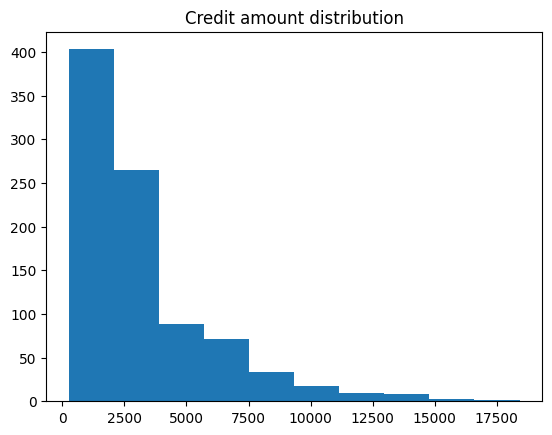

In [31]:
plt.hist(df_train['Credit amount'])
plt.title('Credit amount distribution')
extreme_count(3, feat = 'Credit amount')

(array([160., 240., 299.,  48.,  77.,  17.,  44.,   1.,  13.,   1.]),
 array([ 4. , 10.8, 17.6, 24.4, 31.2, 38. , 44.8, 51.6, 58.4, 65.2, 72. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Duration distribution')

instances of Duration greater than 3 sigma (56.79160849354806 cutoff) are 14 over 900


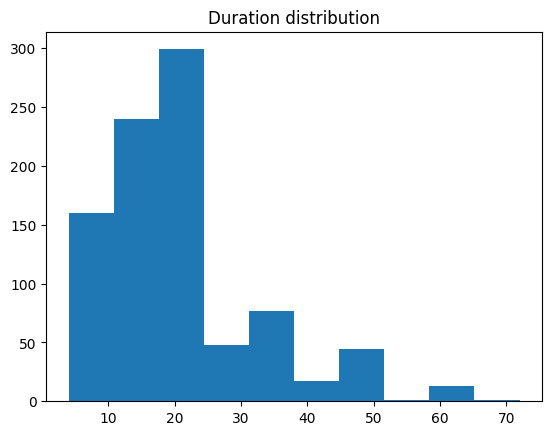

In [32]:
plt.hist(df_train['Duration'])
plt.title('Duration distribution')
extreme_count(3, feat = 'Duration')

In [ ]:
''' Even if there are certain instances where the above features are beyond 3sigma of their mean value, they dont appear to be 
outliers, as its legible to have certain certain loans with high credit value, or loan duration is longer, or older population 
is seeking loan. Hence, I am not eliminating these rows'''

In [33]:
# Finding Missing values, checking if they are legitimate and applying apt transformation

df_train.isnull().sum()

Credit History       0
Age                  0
Gender               0
Job                  0
Housing              0
Saving accounts    163
Credit amount        0
Duration             0
Purpose              0
Risk                 0
dtype: int64

In [34]:
### NaN is a valid field here implying no saving account

df_train['Saving accounts'].value_counts()
df_train['Saving accounts'].unique()

### So, replacing NaN with 'no account'
df_train.loc[df_train['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'

### Replaced in df
df_train['Saving accounts'].value_counts()
df_train['Saving accounts'].unique()

### No NaNs anymore
df_train.isnull().sum()

Saving accounts
little        545
moderate       91
quite rich     58
rich           43
Name: count, dtype: int64

array(['little', nan, 'quite rich', 'rich', 'moderate'], dtype=object)

Saving accounts
little        545
no account    163
moderate       91
quite rich     58
rich           43
Name: count, dtype: int64

array(['little', 'no account', 'quite rich', 'rich', 'moderate'],
      dtype=object)

Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64

In [35]:
# Checking data types and categorical states of features for encoding
df_train.dtypes

Credit History      int64
Age                 int64
Gender             object
Job                 int64
Housing            object
Saving accounts    object
Credit amount       int64
Duration            int64
Purpose            object
Risk               object
dtype: object

In [36]:
df_train.nunique()

Credit History       5
Age                 53
Gender               2
Job                  4
Housing              3
Saving accounts      5
Credit amount      838
Duration            33
Purpose              8
Risk                 2
dtype: int64

In [38]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Credit History   1000 non-null   int64 
 1   Age              1000 non-null   int64 
 2   Gender           1000 non-null   object
 3   Job              1000 non-null   int64 
 4   Housing          1000 non-null   object
 5   Saving accounts  817 non-null    object
 6   Credit amount    1000 non-null   int64 
 7   Duration         1000 non-null   int64 
 8   Purpose          1000 non-null   object
 9   Risk             1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


In [40]:
df_dtypes = pd.DataFrame((df_credit.dtypes == 'object'), columns = ['obj_type'])
df_dtypes

,obj_type
Credit History,False
Age,False
Gender,True
Job,False
Housing,True
Saving accounts,True
Credit amount,False
Duration,False
Purpose,True
Risk,True


In [41]:
obj_list = df_dtypes[(df_dtypes.obj_type == True)].index

print("Features for label encoding:", obj_list)

Features for label encoding: Index(['Gender', 'Housing', 'Saving accounts', 'Purpose', 'Risk'], dtype='object')


In [42]:
le_obj = LabelEncoder()
for feat in obj_list:
    df_train[feat] = le_obj.fit_transform(df_train[feat])
df_train

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
281,2,50,1,2,1,0,1574,12,4,1
72,4,51,1,3,0,0,1164,8,7,1
129,4,29,0,2,1,0,3499,12,1,0
39,2,24,1,2,1,0,458,9,5,1
597,0,36,1,1,1,0,4241,24,0,0
...,...,...,...,...,...,...,...,...,...,...
900,4,43,1,2,2,0,2625,16,1,0
511,2,32,1,3,0,0,4686,36,1,1
404,3,43,1,2,1,2,2899,18,1,1
567,4,34,1,2,1,4,2578,24,5,1


In [43]:
# Distribution of Risk variable

df_train.Risk.value_counts()

Risk
1    631
0    269
Name: count, dtype: int64

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
Credit History,1.000000,0.169364,0.071458,0.023583,-0.078224,0.030897,-0.048511,-0.063852,0.021101,0.230581
Age,0.169364,1.000000,0.140657,-0.002827,-0.306267,0.066855,0.018938,-0.039227,-0.068341,0.092014
Gender,0.071458,0.140657,1.000000,0.077521,-0.207780,0.020999,0.094415,0.088978,-0.071689,0.055683
Job,0.023583,-0.002827,0.077521,1.000000,-0.112274,-0.010061,0.298688,0.216703,-0.010865,-0.051042
Housing,-0.078224,-0.306267,-0.207780,-0.112274,1.000000,0.007262,-0.168318,-0.167141,0.034526,-0.023428
Saving accounts,0.030897,0.066855,0.020999,-0.010061,0.007262,1.000000,-0.003814,0.000863,-0.032987,0.169349
Credit amount,-0.048511,0.018938,0.094415,0.298688,-0.168318,-0.003814,1.000000,0.631147,-0.138155,-0.148980
Duration,-0.063852,-0.039227,0.088978,0.216703,-0.167141,0.000863,0.631147,1.000000,-0.065852,-0.208445
Purpose,0.021101,-0.068341,-0.071689,-0.010865,0.034526,-0.032987,-0.138155,-0.065852,1.000000,0.050905
Risk,0.230581,0.092014,0.055683,-0.051042,-0.023428,0.169349,-0.148980,-0.208445,0.050905,1.000000


<Axes: >

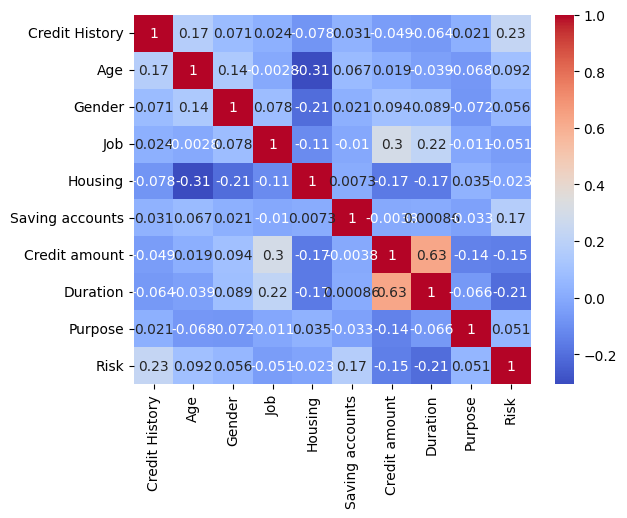

In [46]:
import seaborn as sns

df_train.corr()
### Credit amount and Duration have high correlation relatively and can be considered in feature selection step to drop 'Duration'
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')

(array([[ 22.,   0.,  26.,   0.,   0., 150.,   0.,  27.,   0.,  44.],
        [ 12.,   0.,  21.,   0.,   0., 325.,   0.,  52.,   0., 221.]]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 2 BarContainer objects>)

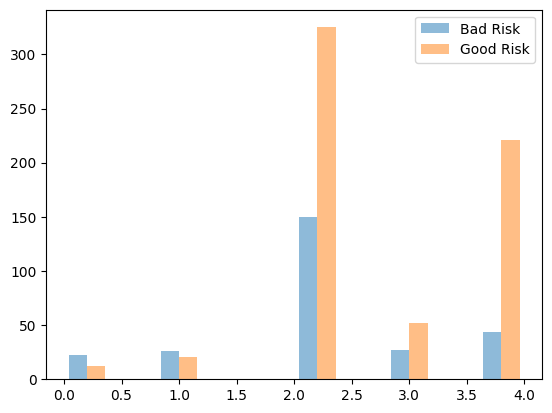

In [47]:
# Ques1 : More credit history is equivalent to credit worthiness

plt.hist([df_train.loc[df_train['Risk'] == 0, 'Credit History'].values, 
          df_train.loc[df_train['Risk'] == 1, 'Credit History'].values], 
          alpha=0.5, label=['Bad Risk', 'Good Risk'])
plt.legend(loc='upper right')

In [51]:
df_train[df_train['Risk'] == 0]['Credit History'].value_counts(), 
df_train[df_train['Risk'] == 1]['Credit History'].value_counts(),
df_train['Credit History'].value_counts()

(Credit History
 2    150
 4     44
 3     27
 1     26
 0     22
 Name: count, dtype: int64,)

(Credit History
 2    325
 4    221
 3     52
 1     21
 0     12
 Name: count, dtype: int64,)

Credit History
2    475
4    265
3     79
1     47
0     34
Name: count, dtype: int64

In [52]:
df_train[df_train['Risk'] == 0]['Credit History'].value_counts()/df_train['Credit History'].value_counts(),
df_train[df_train['Risk'] == 1]['Credit History'].value_counts()/df_train['Credit History'].value_counts(),

(Credit History
 2    0.315789
 4    0.166038
 3    0.341772
 1    0.553191
 0    0.647059
 Name: count, dtype: float64,)

(Credit History
 2    0.684211
 4    0.833962
 3    0.658228
 1    0.446809
 0    0.352941
 Name: count, dtype: float64,)

(array([[ 50.,  81.,  44.,  32.,  25.,  13.,  13.,   6.,   4.,   1.],
        [ 79., 157., 111., 112.,  57.,  53.,  25.,  16.,  15.,   6.]]),
 array([19. , 24.6, 30.2, 35.8, 41.4, 47. , 52.6, 58.2, 63.8, 69.4, 75. ]),
 <a list of 2 BarContainer objects>)

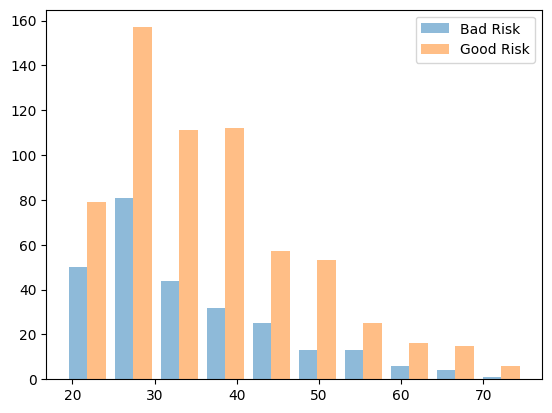

In [54]:
# Ques2 : Are young people more credit worthy? Yes

plt.hist([df_train.loc[df_train['Risk'] == 0, 'Age'].values, df_train.loc[df_train['Risk'] == 1, 'Age'].values], alpha=0.5, label=['Bad Risk', 'Good Risk'])
plt.legend(loc='upper right')

In [55]:
df_train.Age[df_train.Age <= 30] = 0
df_train.Age[(df_train.Age > 30) & (df_train.Age < 45)] = 1
df_train.Age[(df_train.Age >= 45)] = 2

In [56]:
df_train[df_train['Risk'] == 0]['Age'].value_counts()
df_train[df_train['Risk'] == 1]['Age'].value_counts()

Age
0    131
1     94
2     44
Name: count, dtype: int64

Age
1    258
0    236
2    137
Name: count, dtype: int64

(array([[194.,   0.,  28.,   0.,   0.,  31.,   0.,  10.,   0.,   6.],
        [351.,   0.,  63.,   0.,   0., 132.,   0.,  48.,   0.,  37.]]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 2 BarContainer objects>)

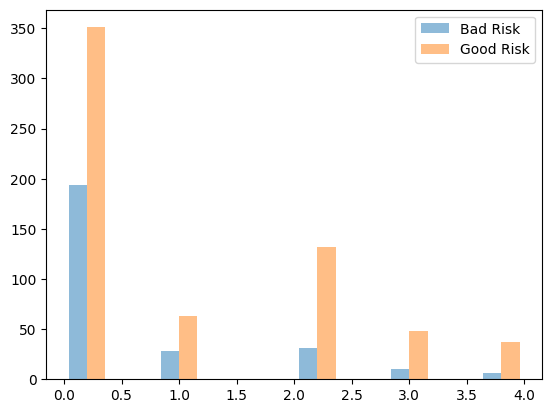

In [57]:
# More saving accounts equivalent to more credit worthy? Inconclusive

plt.hist([df_train.loc[df_train['Risk'] == 0, 'Saving accounts'].values, df_train.loc[df_train['Risk'] == 1, 'Saving accounts'].values], alpha=0.5, label=['Bad Risk', 'Good Risk'])
plt.legend(loc='upper right')

In [58]:
df_train['Saving accounts'].value_counts()

Saving accounts
0    545
2    163
1     91
3     58
4     43
Name: count, dtype: int64

In [59]:
df_train[df_train['Risk'] == 0]['Saving accounts'].value_counts()
df_train[df_train['Risk'] == 1]['Saving accounts'].value_counts()

Saving accounts
0    194
2     31
1     28
3     10
4      6
Name: count, dtype: int64

Saving accounts
0    351
2    132
1     63
3     48
4     37
Name: count, dtype: int64

In [60]:
y_train = df_train['Risk']
X_train = df_train.drop(columns = ['Risk'])

In [62]:
df_test.isnull().sum()
### So, replacing NaN with 'no account'
df_test.loc[df_test['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'
df_test.isnull().sum()

Credit History      0
Age                 0
Gender              0
Job                 0
Housing             0
Saving accounts    20
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64

In [63]:
le_obj = LabelEncoder()
for feat in obj_list:
    df_test[feat] = le_obj.fit_transform(df_test[feat])
df_test

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
912,2,25,0,2,1,2,2991,30,5,1
892,4,38,1,1,1,0,2171,12,1,1
248,2,26,1,2,1,0,1925,24,4,1
469,3,35,1,1,1,0,4679,24,1,1
798,3,54,1,2,1,2,717,24,1,1
...,...,...,...,...,...,...,...,...,...,...
113,4,25,0,2,1,0,7855,36,1,0
618,2,21,0,2,2,1,3441,30,4,0
5,2,35,1,1,0,2,9055,36,3,1
446,2,34,0,2,1,0,1842,36,1,0


In [65]:
train_cols = df_train.columns.tolist()
train_cols
test_cols = df_test.columns.tolist()
test_cols

['Credit History',
 'Age',
 'Gender',
 'Job',
 'Housing',
 'Saving accounts',
 'Credit amount',
 'Duration',
 'Purpose',
 'Risk']

['Credit History',
 'Age',
 'Gender',
 'Job',
 'Housing',
 'Saving accounts',
 'Credit amount',
 'Duration',
 'Purpose',
 'Risk']

In [66]:
delta_cols = list(set(train_cols).difference(test_cols))
delta_cols

[]

In [70]:
y_test = df_test['Risk']
X_test = df_test.drop(columns = ['Risk'])

In [71]:
import numpy as np
from sklearn.metrics import fbeta_score, make_scorer

ftwo_scorer = make_scorer(fbeta_score, beta=1/5)
### To avoid to classify a customer as good when they are bad i.e. objective is to reduce FP, we want better precision 
### Hence, applying beta = 1/5 and selecting fbeta_score as evaluation metric
fbeta_mu_score, fbeta_sigma_score = [], []
model_list = [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()]
for model in model_list:
    obj = model
    scores = cross_val_score(obj, X_train, y_train, cv=5, scoring = ftwo_scorer)
    fbeta_mu_score.append(np.mean(scores))
    fbeta_sigma_score.append(np.std(scores))

In [72]:
fbeta_mu_score
fbeta_sigma_score

[0.7367346116737055, 0.7619243350245732, 0.7480558867864884]

[0.023449872560600573, 0.01406546688517996, 0.015965589792591613]

In [73]:
model_index = fbeta_mu_score.index(max(fbeta_mu_score))
selected_model = model_list[model_index]
selected_model

RandomForestClassifier()

In [74]:
selected_model = RandomForestClassifier(max_depth=3, min_samples_leaf=50)
selected_model.fit(X_train, y_train)
y_pred = selected_model.predict(X_test)
fbeta_score(y_test, y_pred, beta=1/5)

RandomForestClassifier(max_depth=3, min_samples_leaf=50)

0.719326383319968

In [75]:
# porcatone feature importance

df_feat = pd.DataFrame()
df_feat['cols'] = X_train.columns
if str(selected_model)[:3] == 'Log' :
    df_feat['importance'] = np.abs(selected_model.coef_[0])
else:
    df_feat['importance'] = selected_model.feature_importances_
    
df_feat

,cols,importance
0,Credit History,0.233363
1,Age,0.042733
2,Gender,0.013579
3,Job,0.004213
4,Housing,0.036744
5,Saving accounts,0.155373
6,Credit amount,0.235205
7,Duration,0.256891
8,Purpose,0.021898


In [76]:
top_3 = list(df_feat.sort_values(by = 'importance', ascending = False).head(3)['cols'].values)
print("top 3 features:", top_3)
print("Top 3 features' cumulative importance:", np.round(100*df_feat.sort_values(by = 'importance', ascending = False).head(3)['importance'].sum()))


top 3 features: ['Duration', 'Credit amount', 'Credit History']
Top 3 features' cumulative importance: 73.0


In [77]:
df_test.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
912,2,25,0,2,1,2,2991,30,5,1
892,4,38,1,1,1,0,2171,12,1,1
248,2,26,1,2,1,0,1925,24,4,1
469,3,35,1,1,1,0,4679,24,1,1
798,3,54,1,2,1,2,717,24,1,1


In [79]:
# Interpretibility
### Supply the index of specific test row

row_idx = 47
max_display  = 300

data_for_prediction = X_test.iloc[row_idx]
data_for_prediction = np.array(data_for_prediction).reshape(1,-1)

data_for_prediction

array([[   2,   28,    1,    2,    1,    0, 4169,   24,    4]],
      dtype=int64)

In [80]:
# Calculate Shap values
# calculating SHAP values for a specific row enhances model interpretability and provides context-specific insights.
# For critical predictions (e.g., medical diagnoses, loan approvals), understanding feature effects at the instance level is crucial.
# It allows domain experts to validate and refine model decisions.

explainer = shap.TreeExplainer(selected_model)
shap_values = explainer.shap_values(data_for_prediction)

shap_values

[array([[ 2.38715117e-02, -1.14645668e-02, -1.53633911e-03,
          1.43342047e-05, -3.83595967e-03,  2.77773396e-02,
          5.02466987e-02,  1.66681117e-02,  2.08517538e-03]]),
 array([[-2.38715117e-02,  1.14645668e-02,  1.53633911e-03,
         -1.43342047e-05,  3.83595967e-03, -2.77773396e-02,
         -5.02466987e-02, -1.66681117e-02, -2.08517538e-03]])]

In [81]:
pred_probability = selected_model.predict_proba(data_for_prediction)
prediction = np.argmax(pred_probability)
print("prediction: ", prediction, pred_probability)

prediction:  1 [[0.40347075 0.59652925]]


In [82]:
shap_value = shap_values[prediction]

shap_value

array([[-2.38715117e-02,  1.14645668e-02,  1.53633911e-03,
        -1.43342047e-05,  3.83595967e-03, -2.77773396e-02,
        -5.02466987e-02, -1.66681117e-02, -2.08517538e-03]])

In [88]:
feature_order = np.argsort(np.sum(np.abs(shap_value), axis=0))
feature_order = np.flip(feature_order[-min(max_display, len(feature_order)):], 0)

feature_order

array([6, 5, 0, 7, 1, 4, 8, 2, 3], dtype=int64)

In [90]:
top_shape_vals = [shap_value[0][i] for i in feature_order]
top_shape_vals
top_feature_names = [train_cols[i] for i in feature_order]
top_feature_names

[-0.050246698746127326,
 -0.027777339555688698,
 -0.023871511673377983,
 -0.01666811170216927,
 0.011464566849038581,
 0.0038359596735079013,
 -0.0020851753763399803,
 0.001536339113535067,
 -1.4334204665392342e-05]

['Credit amount',
 'Saving accounts',
 'Credit History',
 'Duration',
 'Age',
 'Housing',
 'Purpose',
 'Gender',
 'Job']

<BarContainer object of 9 artists>

([<matplotlib.axis.YTick at 0x21bb154d280>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8')])

[Text(0, 0, 'Job'),
 Text(0, 1, 'Gender'),
 Text(0, 2, 'Purpose'),
 Text(0, 3, 'Housing'),
 Text(0, 4, 'Age'),
 Text(0, 5, 'Duration'),
 Text(0, 6, 'Credit History'),
 Text(0, 7, 'Saving accounts'),
 Text(0, 8, 'Credit amount')]

Text(0.5, 1.0, 'Feature Importance')

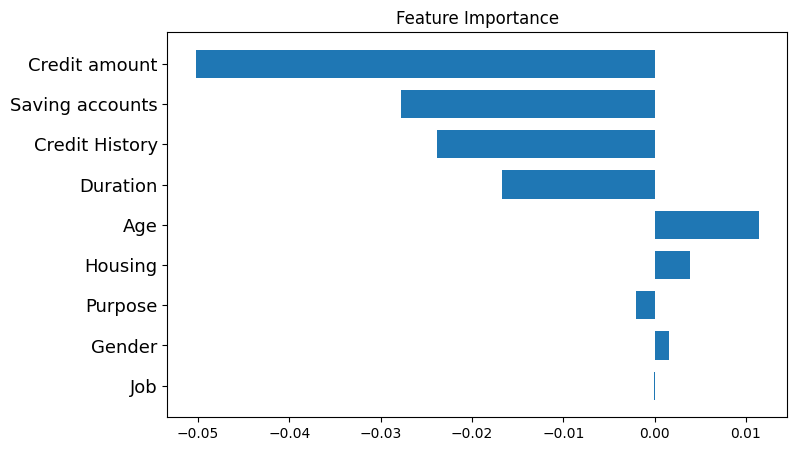

In [91]:
fig = plt.figure(figsize=(8,5))
y_pos = np.arange(len(top_feature_names))

values = np.flip(top_shape_vals)
features = np.flip(top_feature_names)

plt.barh(y_pos, values, 0.7, align='center')
plt.yticks(y_pos, fontsize=13)
plt.gca().set_yticklabels(features)
plt.title("Feature Importance")